In [ ]:
import pandas as pd
import json
import re
from pandarallel import pandarallel
from glob import glob
pandarallel.initialize(nb_workers=4, progress_bar=True)

In [ ]:
def preprocess(text):
    text = re.sub(
        r'[^a-zaăâáắấàằầảẳẩãẵẫạặậđeêéếèềẻểẽễẹệiíìỉĩịoôơóốớòồờỏổởõỗỡọộợuưúứùừủửũữụựyýỳỷỹỵ \
            A-ZAĂÂÁẮẤÀẰẦẢẲẨÃẴẪẠẶẬĐEÊÉẾÈỀẺỂẼỄẸỆIÍÌỈĨỊOÔƠÓỐỚÒỒỜỎỔỞÕỖỠỌỘỢUƯÚỨÙỪỦỬŨỮỤỰYÝỲỶỸỴ\(\)\{\}\,\.\:\-\%\?\!0-9\s]+', 
        ' ', text)
    text = re.sub(r'[\=\~\@\$\^\&\*\*\"\']+', ' ', text)
    text = re.sub(f' +', ' ', text)
    return text

def load_docs(path="../data/docs"):
    txt_paths = glob(path+"/*.txt")
    datas = []
    for path in txt_paths:
        with open(path, "r", encoding="utf-8") as f:
            data = f.readlines()
            data = [preprocess(line) for line in data if len(line.strip()) > 0]
        datas.append(data)
    return datas

docs = load_docs()

In [ ]:
max_overlap_length = 128
max_length = 256

In [ ]:
def split_doc_in_sent_level(doc, max_length=256, max_overlap_length=128):
    chunks = []
    current_chunk = ""
    current_length = 0
    
    index = 0
    remain_overlap_length = max_overlap_length
    while index < len(doc):
        sent = doc[index]
        if current_length + len(sent.split(" ")) > max_length:
            chunks.append(current_chunk)
            while len(doc[index].split(" ")) < remain_overlap_length:
                remain_overlap_length -=len(doc[index].split(" "))
                if index == 0:
                    break
                index -= 1
            index += 1
            if index == len(doc):
                break
            current_chunk = doc[index]
            current_length = len(current_chunk.split(" "))
            remain_overlap_length = max_overlap_length
        else:
            current_chunk = current_chunk + " " + sent
            current_length = len(current_chunk.split(" "))
        
        index += 1
    chunks.append(current_chunk)
    
    return chunks

In [ ]:
chunks

In [3]:
chunks_df = pd.DataFrame(chunks, columns=["chunk"])
chunks_df.head()

NameError: name 'chunks' is not defined

In [4]:
path = "../outputs/chunks/sent_chunks.csv"
chunks_df = pd.read_csv(path)

In [5]:
chunks_df["length"] = chunks_df.chunk.parallel_apply(lambda x: len(x.split(" ")))

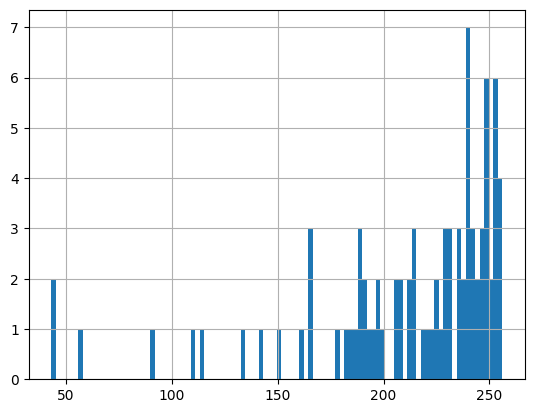

In [7]:
chunks_df.length.hist(bins=100)

In [ ]:
chunks_df[["chunk"]].to_csv("../outputs/chunks/sent_chunks.csv")